In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import time
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast


In [4]:
from PIL import Image

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
data_dir="/content/drive/MyDrive/my_project/Project"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(224, 224))
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(224, 224))


Found 300 files belonging to 2 classes.
Using 240 files for training.
Found 300 files belonging to 2 classes.
Using 60 files for validation.


In [19]:
rescale = tf.keras.layers.Rescaling(1./255, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=0.35)

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
base_model.trainable = False
feat_extr = base_model

In [28]:
augmen = tf.keras.Sequential([RandomFlip('horizontal'),RandomRotation(0.2)])
train_ds = train_ds.map(lambda x, y: (augmen(x), y))
val_ds = val_ds.map(lambda x, y: (augmen(x), y))

In [31]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(3,activation='softmax')
MODEL_INPUT_SIZE = (224, 224, 3)

In [32]:
inputs = tf.keras.Input(shape=MODEL_INPUT_SIZE)
x = global_avg_layer(feat_extr.layers[-1].output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = dense_layer(x)
model = Model(inputs=feat_extr.inputs,outputs=outputs)

In [33]:
lr = 0.0005
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [34]:
history=model.fit(train_ds,validation_data=val_ds,epochs=30)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.3768 - loss: 1.2096 - val_accuracy: 0.4333 - val_loss: 0.8701
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4701 - loss: 0.9080 - val_accuracy: 0.6167 - val_loss: 0.6876
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5787 - loss: 0.7021 - val_accuracy: 0.7833 - val_loss: 0.5288
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7598 - loss: 0.5417 - val_accuracy: 0.7333 - val_loss: 0.5059
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8064 - loss: 0.4749 - val_accuracy: 0.7500 - val_loss: 0.4656
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8346 - loss: 0.4408 - val_accuracy: 0.8667 - val_loss: 0.3887
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7998 - loss: 0.4302 - val_accuracy: 0.9167 - val_loss: 0.3286
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8387 - loss: 0.3907 - val_accuracy: 0.9000 - val_loss: 0.3396
Epoch 9/

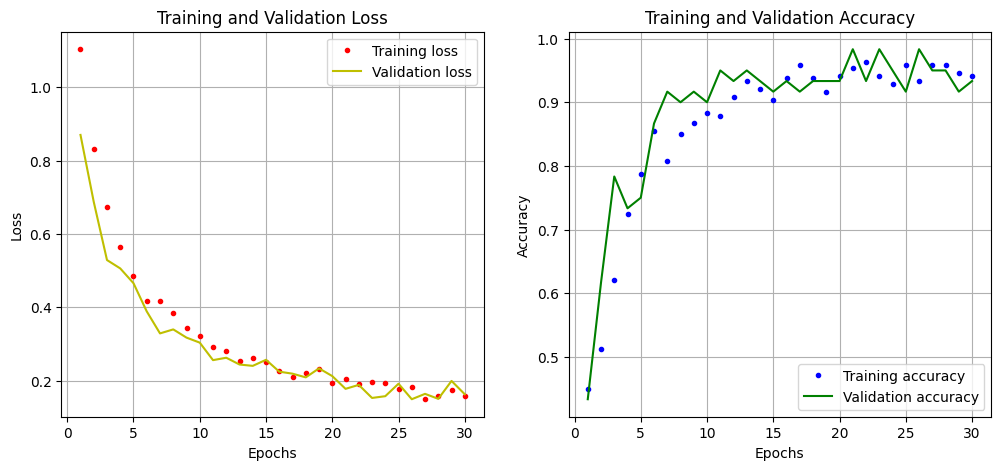

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract loss and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b.', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Save the plots
plt.savefig('.\\figures\\history_training.png', dpi=300, bbox_inches='tight')
plt.show()



In [39]:
model.save("/content/drive/MyDrive/my_project/CSSV_01.keras")

In [43]:
import tensorflow as tf


model = tf.keras.models.load_model("/content/drive/MyDrive/my_project/CSSV_01.keras")


converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open("/content/drive/MyDrive/my_project/CSSV_01.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpv8slulut'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132349744946992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865608288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865610400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349744951744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349744954032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865614976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865611984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865619200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865614624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132349865613392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1323498656209